# **1- Importing Libraries**

In [ ]:
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import random
import shutil

import subprocess
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv3D, MaxPooling3D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

from moviepy import VideoFileClip
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

## **2-Exploratory Data Analysis**

/tmp/ipykernel_213974/3020151254.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(actions), y=list(counts), palette="viridis")


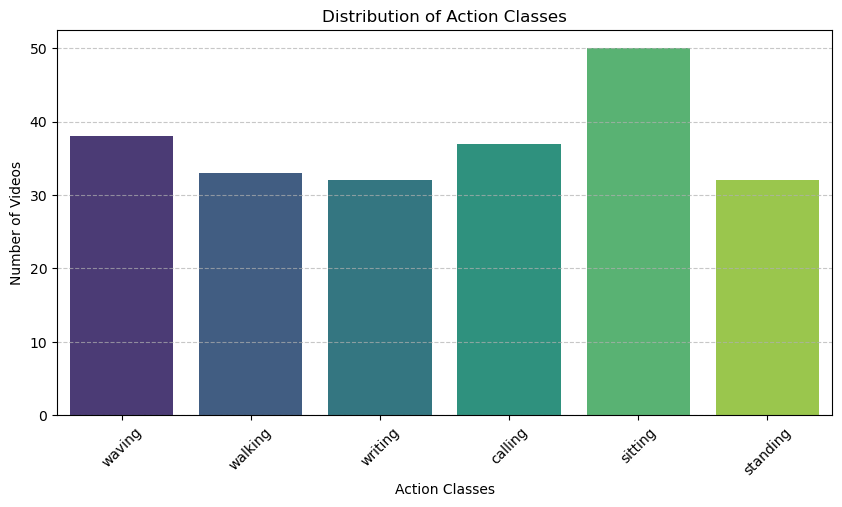

Number of action classes: 6


In [ ]:

# Define dataset paths (update with your actual paths)
DATASET_PATHS = {
    "waving": "/home/student/Documents/Programming-Exercises/projects/Human action/waving",
    "walking": "/home/student/Documents/Programming-Exercises/projects/Human action/walking",
    "writing": "/home/student/Documents/Programming-Exercises/projects/Human action/writing",
    "calling": "/home/student/Documents/Programming-Exercises/projects/Human action/calling",
    "sitting": "/home/student/Documents/Programming-Exercises/projects/Human action/sitting",
    "standing": "/home/student/Documents/Programming-Exercises/projects/Human action/standing",
}

# Count videos per class
class_counts = {action: len(os.listdir(path)) for action, path in DATASET_PATHS.items()}

# Convert to lists for plotting
actions, counts = zip(*class_counts.items())

# Plot distribution of action classes
plt.figure(figsize=(10, 5))
sns.barplot(x=list(actions), y=list(counts), palette="viridis")
plt.title("Distribution of Action Classes")
plt.xlabel("Action Classes")
plt.ylabel("Number of Videos")
plt.xticks(rotation=45)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()

# Print number of unique action classes
num_classes = len(class_counts)
print(f"Number of action classes: {num_classes}")


# **3-Data Preprocessing**


## **a-Conversion of videos from mov to mp4 and taking 30fps**

### converting all mov extension videos to mp4

CONVERTED_VIDEOS_PATH = "/home/student24/Documents/Review_blocks/Review_Block_4/Deep learning/Assignment/Presentation/converted_videos"
os.makedirs(CONVERTED_VIDEOS_PATH, exist_ok=True)

def convert_to_mp4(video_path, output_path):
    """Convert video to MP4 format."""
    command = f"ffmpeg -i '{video_path}' -q:v 0 -q:a 0 '{output_path}' -y"
    subprocess.run(command, shell=True, stdout=subprocess.PIPE, stderr=subprocess.PIPE)

# Convert all videos to MP4
for class_name, class_path in DATASET_PATHS.items():
    for video_file in os.listdir(class_path):
        video_path = os.path.join(class_path, video_file)

        if video_file.endswith(".MOV"):  # Convert only MOV files
            mp4_file = video_file.replace(".MOV", ".mp4")
            mp4_path = os.path.join(CONVERTED_VIDEOS_PATH, mp4_file)

            print(f"Converting {video_file} to {mp4_file}...")
            convert_to_mp4(video_path, mp4_path)

        elif video_file.endswith(".mp4"):  # Copy existing MP4s
            mp4_path = os.path.join(CONVERTED_VIDEOS_PATH, video_file)
            os.system(f"cp '{video_path}' '{mp4_path}'")  # Copy to new folder

print("✅ All videos are now in MP4 format!")


## **B-Converting all videos to frames**

In [ ]:
# Paths
CONVERTED_VIDEOS_PATH = "/home/student/Documents/Programming-Exercises/projects/Human action/converted_videos"
PROCESSED_FRAMES_PATH = "/home/student/Documents/Programming-Exercises/projects/Human action/processed_frames"

# Create processed frames directory
os.makedirs(PROCESSED_FRAMES_PATH, exist_ok=True)

def extract_frames(video_path, class_name, num_frames=30):
    cap = cv2.VideoCapture(video_path)
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    
    if total_frames == 0:
        print(f"⚠️ Skipping {video_path}: No frames detected!")
        return

    frame_idxs = np.linspace(0, total_frames - 1, num_frames, dtype=int)
    video_name = os.path.basename(video_path).split('.')[0]  # Remove extension
    
    # Ensure frames are saved under processed_frames/class_name/
    class_dir = os.path.join(PROCESSED_FRAMES_PATH, class_name)
    os.makedirs(class_dir, exist_ok=True)
    
    save_dir = os.path.join(class_dir, video_name)  
    os.makedirs(save_dir, exist_ok=True)

    for i, idx in enumerate(frame_idxs):
        cap.set(cv2.CAP_PROP_POS_FRAMES, idx)
        ret, frame = cap.read()
        if not ret:
            break
        frame = cv2.resize(frame, (224, 224))  # Resize to 224x224
        frame_path = os.path.join(save_dir, f"frame_{i:02d}.jpg")
        cv2.imwrite(frame_path, frame)

    cap.release()

# Process all videos in the converted folder
for video_file in os.listdir(CONVERTED_VIDEOS_PATH):
    if video_file.endswith(".mp4"):  # Process only MP4 files
        video_path = os.path.join(CONVERTED_VIDEOS_PATH, video_file)

        # Extract class name from filename (e.g., "calling_01.mp4" → "calling")
        class_name = video_file.split('_')[0]  

        print(f"Extracting frames from {video_file} (Class: {class_name})...")
        extract_frames(video_path, class_name)

print("✅ Frame extraction complete! Check 'processed_frames/'")


Extracting frames from sitting_24.mp4 (Class: sitting)...
Extracting frames from writing_01.mp4 (Class: writing)...
Extracting frames from calling_08.mp4 (Class: calling)...
Extracting frames from writing_27.mp4 (Class: writing)...
Extracting frames from sitting_44.mp4 (Class: sitting)...
Extracting frames from sitting_45.mp4 (Class: sitting)...
Extracting frames from writing_07.mp4 (Class: writing)...
Extracting frames from waving_05.mp4 (Class: waving)...
Extracting frames from walking_13.mp4 (Class: walking)...
Extracting frames from waving_14.mp4 (Class: waving)...
Extracting frames from walking_18.mp4 (Class: walking)...
Extracting frames from sitting_40.mp4 (Class: sitting)...
Extracting frames from walking_32.mp4 (Class: walking)...
Extracting frames from waving_33.mp4 (Class: waving)...
Extracting frames from sitting_34.mp4 (Class: sitting)...
Extracting frames from standing_10.mp4 (Class: standing)...
Extracting frames from standing_01.mp4 (Class: standing)...
Extracting frame

## **C-Undersampling to ensure uniform class distribution**

In [ ]:
# Original dataset path
base_path = "/home/student/Documents/Programming-Exercises/projects/Human action/processed_frames"

# New folder for downsampled data
downsampled_path = "/home/student/Documents/Programming-Exercises/projects/Human action/downsampled"

# Ensure the downsampled directory exists
os.makedirs(downsampled_path, exist_ok=True)

# Get all class folders
class_folders = [f for f in os.listdir(base_path) if os.path.isdir(os.path.join(base_path, f))]

# Find the minimum number of subfolders in any class
min_subfolders = min(len(os.listdir(os.path.join(base_path, folder))) for folder in class_folders)

# Downsample each class
for folder in class_folders:
    folder_path = os.path.join(base_path, folder)
    subfolders = [sf for sf in os.listdir(folder_path) if os.path.isdir(os.path.join(folder_path, sf))]
    
    # Randomly select only `min_subfolders` subfolders
    selected_subfolders = random.sample(subfolders, min_subfolders)
    
    # Create the corresponding class folder in the downsampled directory
    new_class_path = os.path.join(downsampled_path, folder)
    os.makedirs(new_class_path, exist_ok=True)

    for subfolder in selected_subfolders:
        src_subfolder = os.path.join(folder_path, subfolder)
        dest_subfolder = os.path.join(new_class_path, subfolder)
        shutil.copytree(src_subfolder, dest_subfolder)  # Copy the entire subfolder

print(f"Downsampling complete! All classes now have {min_subfolders} subfolders, saved in {downsampled_path}.")


Downsampling complete! All classes now have 32 subfolders, saved in /home/student24/Documents/Review_blocks/Review_Block_4/Deep learning/Assignment/Presentation/downsampled.


## **D-Plotting the original class distribution with downsampled class distribution**

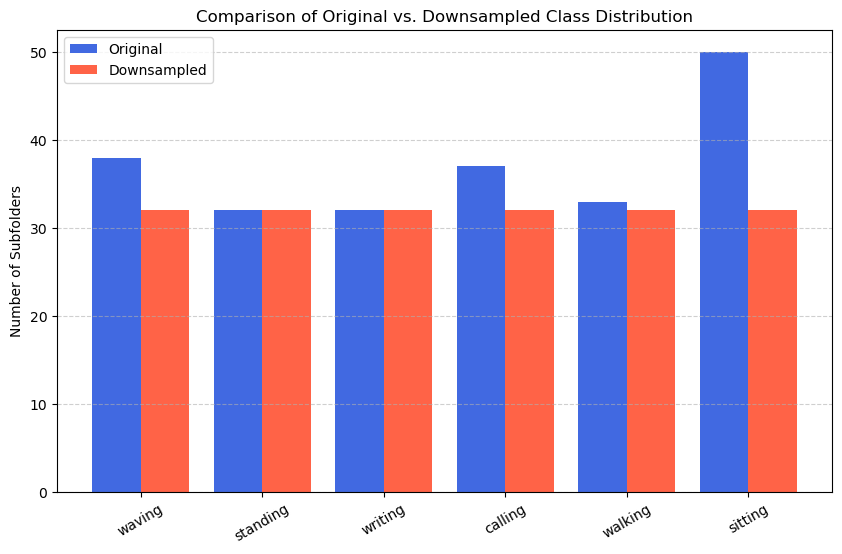

In [ ]:
# Paths
original_path = "/home/student/Documents/Programming-Exercises/projects/Human action/processed_frames"
downsampled_path = "/home/student/Documents/Programming-Exercises/projects/Human action/downsampled"

# Get class folders
class_folders = [f for f in os.listdir(original_path) if os.path.isdir(os.path.join(original_path, f))]

# Count subfolders in each class
original_counts = [len(os.listdir(os.path.join(original_path, folder))) for folder in class_folders]
downsampled_counts = [len(os.listdir(os.path.join(downsampled_path, folder))) for folder in class_folders]

# Plot
x = np.arange(len(class_folders))  # X-axis positions

plt.figure(figsize=(10, 6))
plt.bar(x - 0.2, original_counts, width=0.4, label="Original", color="royalblue")
plt.bar(x + 0.2, downsampled_counts, width=0.4, label="Downsampled", color="tomato")

# Labels
plt.xticks(x, class_folders, rotation=30)
plt.ylabel("Number of Subfolders")
plt.title("Comparison of Original vs. Downsampled Class Distribution")
plt.legend()
plt.grid(axis="y", linestyle="--", alpha=0.6)

# Show plot
plt.show()


## **E-Data Augmentation**
### 1-Flipping the videos

### 2-changing the speed

### 3-cropping the videos and resizing it back to 224

In [ ]:
# Paths
downsampled_path = "/home/student/Documents/Programming-Exercises/projects/Human action/downsampled"
augmented_path = "/home/student/Documents/Programming-Exercises/projects/Human action/augmented"

# Ensure augmented directory exists
os.makedirs(augmented_path, exist_ok=True)

# Data augmentation functions
def flip_image(image):
    """ Horizontally flips the image """
    return cv2.flip(image, 1)

def crop_and_resize(image, size=224):
    """ Random crop and resize back to original size """
    h, w, _ = image.shape
    crop_size = int(0.8 * min(h, w))  # Crop 80% of min dimension
    x = random.randint(0, w - crop_size)
    y = random.randint(0, h - crop_size)
    cropped = image[y:y+crop_size, x:x+crop_size]
    return cv2.resize(cropped, (size, size))

def change_video_speed(video_path, output_path, speed_factor):
    """ Change video speed by speed_factor (0.5 = slow, 2.0 = fast) """
    clip = VideoFileClip(video_path)
    new_clip = clip.fx(vfx.speedx, speed_factor)
    new_clip.write_videofile(output_path, codec="libx264", fps=clip.fps)

# Process each class
for class_name in tqdm(os.listdir(downsampled_path), desc="Processing Classes"):
    class_dir = os.path.join(downsampled_path, class_name)
    new_class_dir = os.path.join(augmented_path, class_name)
    os.makedirs(new_class_dir, exist_ok=True)

    # Process each subfolder (video instance)
    for subfolder in os.listdir(class_dir):
        subfolder_path = os.path.join(class_dir, subfolder)
        new_subfolder_path = os.path.join(new_class_dir, subfolder)
        os.makedirs(new_subfolder_path, exist_ok=True)

        # Process each frame
        for frame_name in os.listdir(subfolder_path):
            frame_path = os.path.join(subfolder_path, frame_name)
            image = cv2.imread(frame_path)

            if image is None:
                continue

            # Save original
            cv2.imwrite(os.path.join(new_subfolder_path, frame_name), image)

            # Apply flipping
            flipped = flip_image(image)
            cv2.imwrite(os.path.join(new_subfolder_path, f"flipped_{frame_name}"), flipped)

            # Apply cropping & resize
            cropped_resized = crop_and_resize(image)
            cv2.imwrite(os.path.join(new_subfolder_path, f"cropped_{frame_name}"), cropped_resized)

print("✅ Augmentation complete! Data saved in 'augmented' folder.")


Processing Classes: 100%|█████████████████████████| 6/6 [00:12<00:00,  2.01s/it]

✅ Augmentation complete! Data saved in 'augmented' folder.


# **4-Splitting Dataset into training and testing**

In [44]:
def load_data(frame_dir, num_classes, num_frames=16, img_size=(224, 224)):
    X = []
    y = []
    class_labels = sorted(os.listdir(frame_dir))  # Get action class names
    label_map = {label: idx for idx, label in enumerate(class_labels)}  # Map class to index
    
    for action in class_labels:
        action_path = os.path.join(frame_dir, action)
        
        for instance in os.listdir(action_path):  # Iterate over video instances
            instance_path = os.path.join(action_path, instance)
            
            frame_paths = sorted(os.listdir(instance_path))[:num_frames]  # Take first `num_frames` frames
            
            frames = []
            for frame in frame_paths:
                img = cv2.imread(os.path.join(instance_path, frame))  # Load image
                img = cv2.resize(img, img_size)  # Resize to 224x224
                img = img / 255.0  # Normalize pixel values
                frames.append(img)

            if len(frames) == num_frames:  # Ensure complete sequences
                X.append(np.array(frames))  # Store as NumPy array
                y.append(label_map[action])  # Store label
    
    # Convert to NumPy arrays
    X = np.array(X)
    y = to_categorical(y, num_classes)  # One-hot encode labels
    
    return X, y, class_labels  # Return class labels


In [47]:
# to identify the class labels,we output the different classes
frame_dir = "/home/student24/Documents/Review_blocks/Review_Block_4/Deep learning/Assignment/Presentation/augmented"  # Update with your dataset path
num_classes = 6  # Adjust based on your dataset

X, y, class_labels = load_data(frame_dir, num_classes)

# Print class labels
print("Class labels:", class_labels)



Class labels: ['calling', 'sitting', 'standing', 'walking', 'waving', 'writing']


In [12]:
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42)
print(f"Train: {X_train.shape}, Validation: {X_val.shape}, Test: {X_test.shape}")

Train: (153, 16, 224, 224, 3), Validation: (19, 16, 224, 224, 3), Test: (20, 16, 224, 224, 3)


## **5-Creating CNN Model**

In [21]:
def create_advanced_3dcnn_model(input_shape, num_classes):
    model = Sequential()
    
    # 3D convolutional layer with 64 filters, kernel size of (3, 3, 3), and ReLU activation
    model.add(Conv3D(32, (3, 3, 3), activation='relu', padding='same', input_shape=input_shape))
    # 3D max pooling layer with pool size of (2, 2, 2)
    model.add(MaxPooling3D((2, 2, 2)))
    # Batch normalization layer
    model.add(BatchNormalization())

    # Another 3D convolutional layer with 128 filters, kernel size of (3, 3, 3), and ReLU activation
    model.add(Conv3D(64, (3, 3, 3), activation='relu', padding='same'))
    # Another 3D max pooling layer with pool size of (2, 2, 2)
    model.add(MaxPooling3D((2, 2, 2)))
    # Another batch normalization layer
    model.add(BatchNormalization())

    # Another 3D convolutional layer with 256 filters, kernel size of (3, 3, 3), and ReLU activation
    model.add(Conv3D(98, (3, 3, 3), activation='relu', padding='same'))
    # Another 3D max pooling layer with pool size of (2, 2, 2)
    model.add(MaxPooling3D((2, 2, 2)))
    # Another batch normalization layer
    model.add(BatchNormalization())

    # Flatten layer to flatten the output of the convolutional layers
    model.add(Flatten())
    # Fully connected (dense) layer with 512 units and ReLU activation
    model.add(Dense(128, activation='relu'))
    # Dropout layer with dropout rate of 0.5
    model.add(Dropout(0.2))
    # Output layer with softmax activation for multi-class classification
    model.add(Dense(num_classes, activation='softmax'))
    
    # Compile the model with Adam optimizer, categorical crossentropy loss, and accuracy metric
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    
    return model

# Define the shape of input frames and create the advanced 3D CNN model
input_shape = (16, 224, 224, 3)
model = create_advanced_3dcnn_model(input_shape, num_classes)


In [22]:
model.summary() 

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv3d_3 (Conv3D)               │ (None, 16, 224, 224,   │         2,624 │
│                                 │ 32)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_3 (MaxPooling3D)  │ (None, 8, 112, 112,    │             0 │
│                                 │ 32)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 8, 112, 112,    │           128 │
│ (BatchNormalization)            │ 32)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_4 (Conv3D)               │ (None, 8, 112, 112,    │        55,360 │
│                                 │ 64)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_4 (MaxPooling3D)  │ (None, 4, 56, 56, 64)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 4, 56, 56, 64)  │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_5 (Conv3D)               │ (None, 4, 56, 56, 98)  │       169,442 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_5 (MaxPooling3D)  │ (None, 2, 28, 28, 98)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 2, 28, 28, 98)  │           392 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 153664)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │    19,669,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 6)              │           774 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 19,898,096 (75.91 MB)

 Trainable params: 19,897,708 (75.90 MB)

 Non-trainable params: 388 (1.52 KB)

In [25]:
# Train the 3D CNN model with validation
history1 = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=20,
    batch_size=8
)

# Evaluate on the test set after training
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")


Epoch 1/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 85s 4s/step - accuracy: 0.9725 - loss: 0.5941 - val_accuracy: 0.4737 - val_loss: 37.2437
Epoch 2/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 75s 4s/step - accuracy: 0.9666 - loss: 1.4941 - val_accuracy: 0.4211 - val_loss: 35.4518
Epoch 3/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 62s 3s/step - accuracy: 0.9689 - loss: 0.8349 - val_accuracy: 0.6842 - val_loss: 22.9164
Epoch 4/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 65s 3s/step - accuracy: 0.9695 - loss: 2.1735 - val_accuracy: 0.5789 - val_loss: 26.6513
Epoch 5/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 65s 3s/step - accuracy: 0.9724 - loss: 0.3635 - val_accuracy: 0.5789 - val_loss: 28.7597
Epoch 6/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 64s 3s/step - accuracy: 0.9925 - loss: 0.1100 - val_accuracy: 0.5263 - val_loss: 23.3851
Epoch 7/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 64s 3s/step - accuracy: 0.9618 - loss: 1.5311 - val_accuracy: 0.7368 - val_loss: 29.2711
Epoch 8/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 64s 3s/step - accuracy: 0.9629 - loss: 0.5831 - val_accuracy: 0.5263 - va

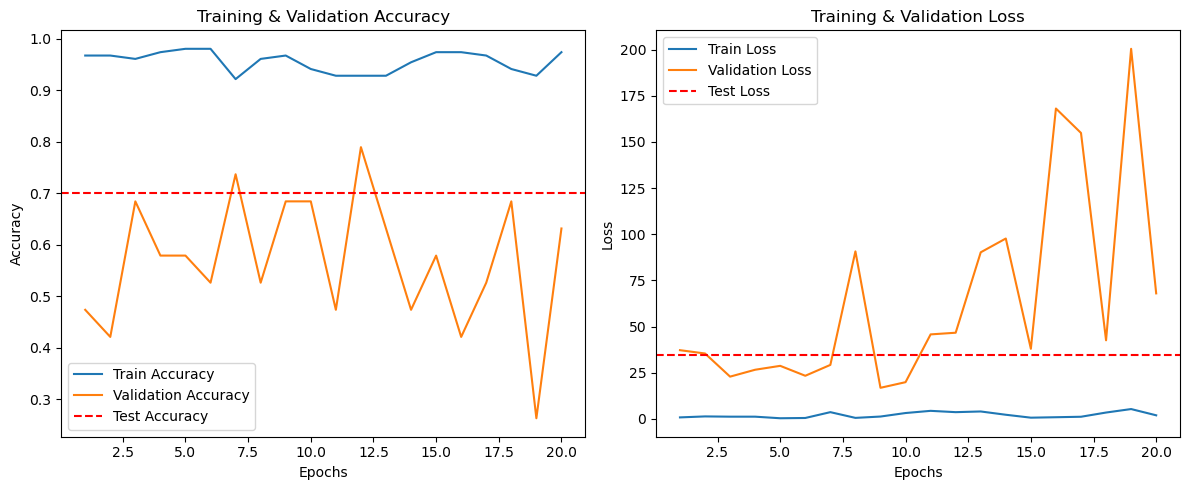

In [27]:
# Extract accuracy and loss values
train_loss = history1.history['loss']
val_loss = history1.history['val_loss']
train_acc = history1.history['accuracy']
val_acc = history1.history['val_accuracy']

# Number of epochs
epochs = range(1, len(train_loss) + 1)

# Plot Accuracy
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, train_acc, label='Train Accuracy')
plt.plot(epochs, val_acc, label='Validation Accuracy')
plt.axhline(y=test_accuracy, color='r', linestyle='--', label='Test Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training & Validation Accuracy')
plt.legend()

# Plot Loss
plt.subplot(1, 2, 2)
plt.plot(epochs, train_loss, label='Train Loss')
plt.plot(epochs, val_loss, label='Validation Loss')
plt.axhline(y=test_loss, color='r', linestyle='--', label='Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training & Validation Loss')
plt.legend()

plt.tight_layout()
plt.show()


## **Using Transfer learning**

In [28]:
# Define input shape (16 frames, 224x224, RGB)
input_shape = (16, 224, 224, 3)
num_classes = 6  # Adjust based on your dataset

# Load MobileNetV2 as a feature extractor
base_model = keras.applications.MobileNetV2(
    input_shape=(224, 224, 3),  # Per-frame shape
    include_top=False,  
    weights="imagenet"
)

# Freeze the base model to retain pretrained weights
base_model.trainable = False


# Define model input
inputs = keras.Input(shape=input_shape)

# Process each frame independently through MobileNetV2
x = layers.TimeDistributed(base_model)(inputs)

# Reduce spatial dimensions
x = layers.TimeDistributed(layers.GlobalAveragePooling2D())(x)

# Temporal processing using LSTM (captures motion over time)
x = layers.Bidirectional(layers.LSTM(128, return_sequences=False))(x)
x = layers.Dense(128, activation="relu")(x)  # **Apply ReLU activation correctly**
x = layers.Dropout(0.3)(x)  # **Apply Dropout correctly**

# **Fix: Connect outputs to x**
outputs = layers.Dense(num_classes, activation="softmax")(x)  # Corrected

# Build the model
model1 = keras.Model(inputs=inputs, outputs=outputs)

# Compile model
model1.compile(optimizer="adam",
              loss="categorical_crossentropy",
              metrics=["accuracy"])

# Print model summary
model1.summary()


Model: "functional_27"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)      │ (None, 16, 224, 224,   │             0 │
│                                 │ 3)                     │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_2              │ (None, 16, 7, 7, 1280) │     2,257,984 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_3              │ (None, 16, 1280)       │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 256)            │     1,442,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 6)              │           774 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,734,470 (14.25 MB)

 Trainable params: 1,476,486 (5.63 MB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [30]:
# Train the model with training, validation, and testing
EPOCHS = 15
history = model1.fit(
    X_train, y_train,  
    validation_data=(X_val, y_val),  
    epochs=EPOCHS,
    batch_size=8
)

# Evaluate on test data
test_loss, test_accuracy = model1.evaluate(X_test, y_test)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")

# Save the trained model
model.save("human_action_recognition.h5")
print("✅ Model training complete! Model saved as 'human_action_recognition.h5'.")



Epoch 1/15
20/20 ━━━━━━━━━━━━━━━━━━━━ 157s 4s/step - accuracy: 0.2469 - loss: 1.7761 - val_accuracy: 0.5789 - val_loss: 1.1460
Epoch 2/15
20/20 ━━━━━━━━━━━━━━━━━━━━ 60s 3s/step - accuracy: 0.6628 - loss: 1.0151 - val_accuracy: 0.6842 - val_loss: 0.8429
Epoch 3/15
20/20 ━━━━━━━━━━━━━━━━━━━━ 78s 4s/step - accuracy: 0.7976 - loss: 0.6461 - val_accuracy: 0.7895 - val_loss: 0.7317
Epoch 4/15
20/20 ━━━━━━━━━━━━━━━━━━━━ 56s 3s/step - accuracy: 0.8332 - loss: 0.5106 - val_accuracy: 0.8947 - val_loss: 0.4883
Epoch 5/15
20/20 ━━━━━━━━━━━━━━━━━━━━ 46s 2s/step - accuracy: 0.8951 - loss: 0.3433 - val_accuracy: 0.7895 - val_loss: 0.5515
Epoch 6/15
20/20 ━━━━━━━━━━━━━━━━━━━━ 46s 2s/step - accuracy: 0.8625 - loss: 0.3742 - val_accuracy: 0.8421 - val_loss: 0.3930
Epoch 7/15
20/20 ━━━━━━━━━━━━━━━━━━━━ 45s 2s/step - accuracy: 0.9188 - loss: 0.3029 - val_accuracy: 0.8421 - val_loss: 0.4384
Epoch 8/15
20/20 ━━━━━━━━━━━━━━━━━━━━ 46s 2s/step - accuracy: 0.9580 - loss: 0.1732 - val_accuracy: 0.9474 - val_loss

Test Loss: 0.4690, Test Accuracy: 0.8500
✅ Model training complete! Model saved as 'human_action_recognition.h5'.


# **plots for scratch and pretrained models:** 

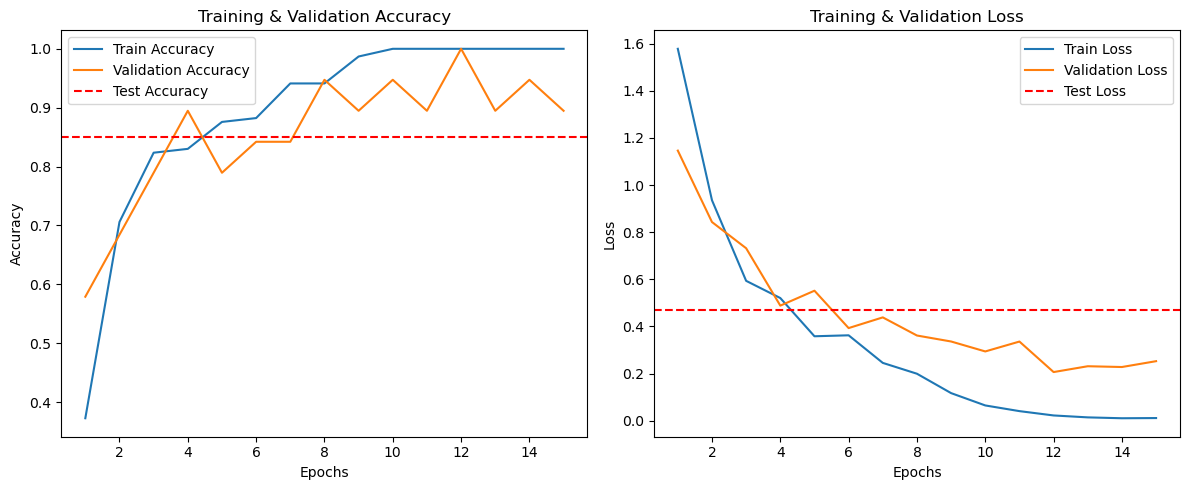

In [31]:
import matplotlib.pyplot as plt

# Extract accuracy and loss values
train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

# Number of epochs
epochs = range(1, len(train_loss) + 1)

# Plot Accuracy
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, train_acc, label='Train Accuracy')
plt.plot(epochs, val_acc, label='Validation Accuracy')
plt.axhline(y=test_accuracy, color='r', linestyle='--', label='Test Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training & Validation Accuracy')
plt.legend()

# Plot Loss
plt.subplot(1, 2, 2)
plt.plot(epochs, train_loss, label='Train Loss')
plt.plot(epochs, val_loss, label='Validation Loss')
plt.axhline(y=test_loss, color='r', linestyle='--', label='Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training & Validation Loss')
plt.legend()

plt.tight_layout()
plt.show()


# **Prediction power of two models: scratch model and pretrained model**

In [32]:
# Predict class probabilities for each sample
y_pred_model = model.predict(X_test)
y_pred_model1 = model1.predict(X_test)

# Convert probabilities to class labels (indices of max probability)
y_pred_classes_model = np.argmax(y_pred_model, axis=1)
y_pred_classes_model1 = np.argmax(y_pred_model1, axis=1)

# Convert true labels to class indices
y_true_classes = np.argmax(y_test, axis=1)  # Assuming one-hot encoded labels

2025-02-19 22:49:46.529527: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 192675840 bytes after encountering the first element of size 192675840 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step


2025-02-19 22:49:52.871590: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 192675840 bytes after encountering the first element of size 192675840 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


1/1 ━━━━━━━━━━━━━━━━━━━━ 30s 30s/step


In [33]:
# Evaluate accuracy and loss for both models
test_loss_model, test_acc_model = model.evaluate(X_test, y_test)
test_loss_model1, test_acc_model1 = model1.evaluate(X_test, y_test)

print(f"3D CNN Model - Test Loss: {test_loss_model:.4f}, Test Accuracy: {test_acc_model:.4f}")
print(f"MobileNet Model - Test Loss: {test_loss_model1:.4f}, Test Accuracy: {test_acc_model1:.4f}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.6000 - loss: 36.8465
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step - accuracy: 0.8500 - loss: 0.4690
3D CNN Model - Test Loss: 36.8465, Test Accuracy: 0.6000
MobileNet Model - Test Loss: 0.4690, Test Accuracy: 0.8500


In [35]:
# Print classification report for 3D CNN Model
print("Classification Report for 3D CNN Model:")
print(classification_report(y_true_classes, y_pred_classes_model, digits=4))

# Print classification report for MobileNet Model
print("Classification Report for MobileNet Model:")
print(classification_report(y_true_classes, y_pred_classes_model1, digits=4))


Classification Report for 3D CNN Model:
              precision    recall  f1-score   support

           0     0.5000    0.6667    0.5714         3
           1     0.2500    0.2500    0.2500         4
           2     0.2500    0.3333    0.2857         3
           3     1.0000    1.0000    1.0000         4
           4     1.0000    0.3333    0.5000         3
           5     1.0000    1.0000    1.0000         3

    accuracy                         0.6000        20
   macro avg     0.6667    0.5972    0.6012        20
weighted avg     0.6625    0.6000    0.6036        20

Classification Report for MobileNet Model:
              precision    recall  f1-score   support

           0     0.7500    1.0000    0.8571         3
           1     1.0000    0.7500    0.8571         4
           2     1.0000    0.6667    0.8000         3
           3     1.0000    1.0000    1.0000         4
           4     0.6667    0.6667    0.6667         3
           5     0.7500    1.0000    0.8571      

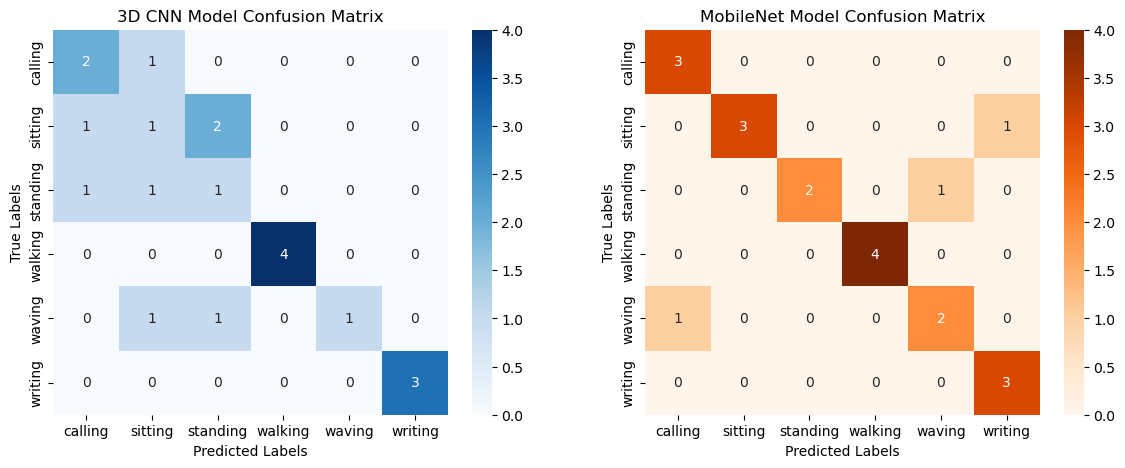

In [ ]:
# Generate confusion matrices
cm_model = confusion_matrix(y_true_classes, y_pred_classes_model)
cm_model1 = confusion_matrix(y_true_classes, y_pred_classes_model1)

# Plot confusion matrices
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# 3D CNN Model Confusion Matrix
sns.heatmap(cm_model, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels, ax=axes[0])
axes[0].set_title("3D CNN Model Confusion Matrix")
axes[0].set_xlabel("Predicted Labels")
axes[0].set_ylabel("True Labels")

# MobileNet Model Confusion Matrix
sns.heatmap(cm_model1, annot=True, fmt="d", cmap="Oranges", xticklabels=class_labels, yticklabels=class_labels, ax=axes[1])
axes[1].set_title("MobileNet Model Confusion Matrix")
axes[1].set_xlabel("Predicted Labels")
axes[1].set_ylabel("True Labels")

plt.show()
